In [18]:
#Importando as bibliotecas
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('dark_background')
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
matplotlib.rcParams['image.cmap'] = 'gray'
#%matplotlib inline

DATA_PATH = r"D:\Estudos\OpenCV\Computer Vision - Introduction\w9 - Video Analysis\data"

## 1 Step: Input Videos

In [19]:
videoFileName  = DATA_PATH + r"\videos\video.mp4"

cap = cv2.VideoCapture(videoFileName)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Get frames per second (fps)
fps = cap.get(cv2.CAP_PROP_FPS)

n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# The larger the more stable the video, but less reactive to sudden panning
SMOOTHING_RADIUS=50

out = cv2.VideoWriter('video_out.avi',cv2.VideoWriter_fourcc('M','J','P','G'),
                      fps, (width*2,height))

## 2 Step: Read Frist Frame

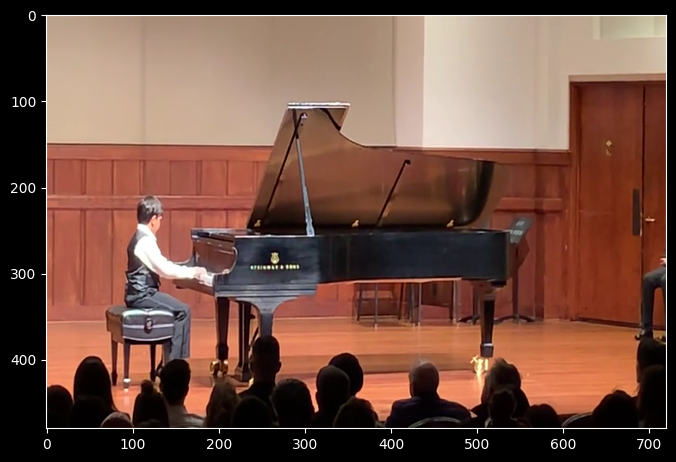

In [20]:
# Read first frame
_, prev = cap.read()

# Convert frame to grayscale
prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
plt.imshow(prev[:,:,::-1]);

## 3 Step: Find Motion between frames

In [24]:
transforms = np.zeros((n_frames -1,3), np.float32)

In [25]:
for i in range(n_frames- 2):
    prev_pts = cv2.goodFeaturesToTrack(prev_gray,
                                       maxCorners=200,
                                       qualityLevel=0.01,
                                       minDistance=30,
                                       blockSize=3)

    sucess, curr = cap.read()

    if not sucess:
        break

    curr_gray = cv2.cvtColor(curr, cv2.COLOR_BGR2GRAY)

    curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray,
                                                     prev_pts, None)

    assert prev_pts.shape == curr_pts.shape

    idx = np.where(status == 1)[0]
    prev_pts = prev_pts[idx]
    curr_pts = curr_pts[idx]

    m = cv2.estimateAffinePartial2D(prev_pts, curr_pts)
    dx = m[0][0,2]
    dy = m[0][1,2]

    da = np.arctan2(m[0][1,0], m[0][0,0])

    transforms[i] = [dx,dy,da]

    prev_gray = curr_gray

    print("Frame: " + str(i) +  "/" + str(n_frames) + " \
    -  Tracked points : " + str(len(prev_pts)))

Frame: 0/1362     -  Tracked points : 106
Frame: 1/1362     -  Tracked points : 106
Frame: 2/1362     -  Tracked points : 107
Frame: 3/1362     -  Tracked points : 107
Frame: 4/1362     -  Tracked points : 110
Frame: 5/1362     -  Tracked points : 110
Frame: 6/1362     -  Tracked points : 102
Frame: 7/1362     -  Tracked points : 109
Frame: 8/1362     -  Tracked points : 104
Frame: 9/1362     -  Tracked points : 107
Frame: 10/1362     -  Tracked points : 109
Frame: 11/1362     -  Tracked points : 108
Frame: 12/1362     -  Tracked points : 104
Frame: 13/1362     -  Tracked points : 109
Frame: 14/1362     -  Tracked points : 103
Frame: 15/1362     -  Tracked points : 106
Frame: 16/1362     -  Tracked points : 104
Frame: 17/1362     -  Tracked points : 110
Frame: 18/1362     -  Tracked points : 102
Frame: 19/1362     -  Tracked points : 104
Frame: 20/1362     -  Tracked points : 103
Frame: 21/1362     -  Tracked points : 103
Frame: 22/1362     -  Tracked points : 102
Frame: 23/1362     - 

## 4 Step: Calculate Smooth Motion

In [38]:
trajectory = np.cumsum(transforms, axis = 0)

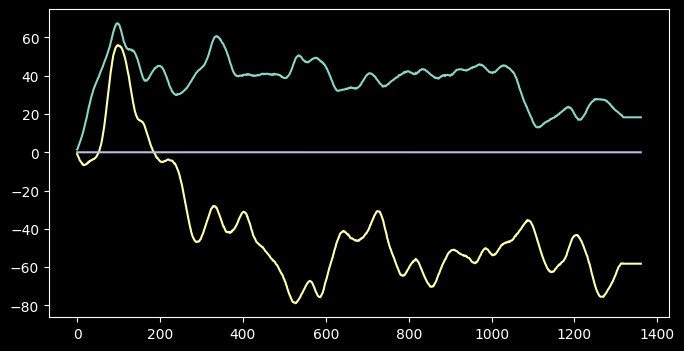

In [39]:
plt.figure(figsize=(8, 4))
plt.plot(trajectory);

In [40]:
def movingAverage(curve, radius):
    window_size = 2 * radius + 1

    f = np.ones(window_size)/window_size

    curve_pad = np.lib.pad(curve, (radius, radius), 'edge')
    curve_smoothed = np.convolve(curve_pad, f, mode='same')
    curve_smoothed = curve_smoothed[radius:-radius]

    return curve_smoothed

In [41]:
def smooth(trajectory):
    smoothed_trajectory = np.copy(trajectory)

    for i in range(3):
        smoothed_trajectory[:,i] = movingAverage(trajectory[:,i],
                                                 radius = SMOOTHING_RADIUS)
    return smoothed_trajectory

In [42]:
tranjectory = np.cumsum(transforms, axis=0)

### Calculate smooth transforms

In [44]:
# Create variable to store smoothed trajectory
smoothed_trajectory = smooth(trajectory)

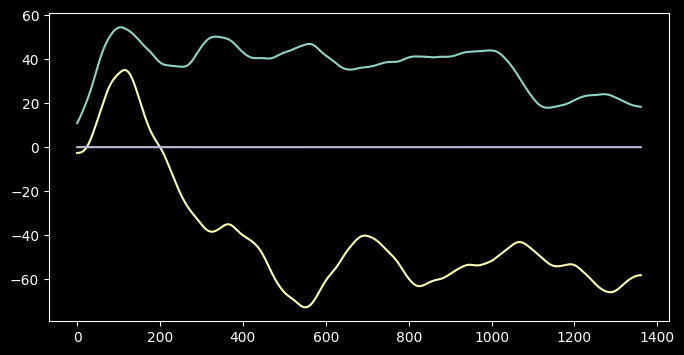

In [47]:
plt.figure(figsize=(8, 4))
plt.plot(smoothed_trajectory);

In [45]:
# Calculate difference in smoothed_trajectory and trajectory
difference = smoothed_trajectory - trajectory

# Calculate newer transformation array
transforms_smooth = transforms + difference

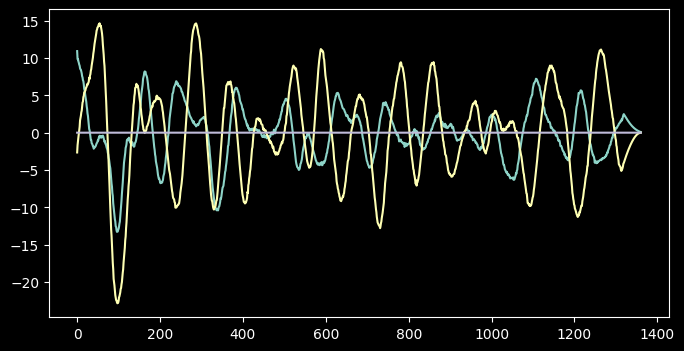

In [46]:
plt.figure(figsize=(8, 4))
plt.plot(transforms_smooth);

### Fix border artifacts

In [48]:
def fixBorder(frame):
    s = frame.shape
    # Scale the image 4% without moving the center
    T = cv2.getRotationMatrix2D((s[1]/2, s[0]/2), 0, 1.04)
    frame = cv2.warpAffine(frame, T, (s[1], s[0]))
    return frame

In [55]:
# Reset stream to first frame
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

True

In [1]:
# Write n_frames-1 transformed frames
for i in range(n_frames-2):
    # Read next frame
    success, frame = cap.read()
    if not success:
        break

    # Extract transformations from the new transformation array
    dx = transforms_smooth[i,0]
    dy = transforms_smooth[i,1]
    da = transforms_smooth[i,2]

    # Reconstruct transformation matrix accordingly to new values
    m = np.zeros((2,3), np.float32)
    m[0,0] = np.cos(da)
    m[0,1] = -np.sin(da)
    m[1,0] = np.sin(da)
    m[1,1] = np.cos(da)
    m[0,2] = dx
    m[1,2] = dy

    # Apply affine wrapping to the given frame
    frame_stabilized = cv2.warpAffine(frame, m, (width,height))

    # Fix border artifacts
    frame_stabilized = fixBorder(frame_stabilized)

    # Write the frame to the file
    frame_out = cv2.hconcat([frame, frame_stabilized])

    # If the image is too big, resize it.
    if(frame_out.shape[1] > 1920):
        frame_out = cv2.resize(frame_out, (width,height))

    cv2.imshow("Frame",frame_out)
    cv2.waitKey(0)

    out.write(frame_out)

cv2.destroyAllWindows()
out.release()

NameError: name 'n_frames' is not defined

https://www.learnopencv.com/video-stabilization-using-point-feature-matching-in-opencv/
https://github.com/AdamSpannbauer/python_video_stab
http://nghiaho.com/?p=2093